# HW: LSH Applications

### In this session we will:

1. take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.
2. take another large sets of articles and detect plagiarization (near-duplicates) sets.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* (n-shingles) of a phrase are overlapping sequences of words of length *n*. For instance, the sentence '*I am a student in Data Science Department.*' has the following 3-grams:

* 'I am a'
* 'am a student'
* 'a student in'
* 'in Data Science'
* 'Data Science Department'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams.



Author: <font color="blue">Ian Liu</font>

E-mail: <font color="blue">Liuusa.tw@gmail.com</font>

Date: <font color="blue">March 8th 2023</font>

# 0. Dataset-1

The corpus you will use is a file named [`CovidLockdownCatalonia.json.gz`](https://cis331.guihang.org/data/lsh/CovidLockdownCatalonia.json.gz) (right click to download). This is a gzip-compressed file, which you can de-compress using the `gunzip` command. The file contain about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as JSON. Python's JSON library takes care of translating it into a dictionary. Play with this 5 min [tutorial](https://www.w3schools.com/python/python_json.asp) if you don't know about json data format, it's a common data format in datascience.

**How was this file obtained?** This file was obtained from the [CrisisNLP](https://crisisnlp.qcri.org/covid19). This is a website that provides COVID-19 collections of tweets, however, they only provide the identifier of the tweet, known as a tweet-id.

To recover the entire tweet, a process commonly known as *re-hydration* needs to be used, which involves querying an API from Twitter, giving the tweet-id, and obtaining the tweet. This can be done with a little bit of programming or using a software such as [twarc](https://github.com/DocNow/twarc#dehydrate).


In [ ]:
!pip install Romanize
!pip install datasketch
!wget https://cis331.guihang.org/data/lsh/CovidLockdownCatalonia.json.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-03-11 01:02:01--  https://cis331.guihang.org/data/lsh/CovidLockdownCatalonia.json.gz
Resolving cis331.guihang.org (cis331.guihang.org)... 173.236.170.235
Connecting to cis331.guihang.org (cis331.guihang.org)|173.236.170.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31517814 (30M) [application/gzip]
Saving to: ‘CovidLockdownCatalonia.json.gz.1’

CovidLockdownCatalo 100%[===================>]  30.06M  19.7MB/s    in 1.5s    

2023-03-11 01:02:03 (19.7 MB/s) - ‘CovidLockdownCatalonia.json.gz.1’ saved [31517814/31517814]



In [ ]:
import io
import json
import gzip
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from time import perf_counter
import time
import datetime
from romanize import romanize
import gc
import datasketch
from datasketch import MinHash, MinHashLSHForest, MinHashLSH
from typing import Sequence
import pdb
from tqdm import tqdm

In [ ]:
# Input file: if this file is not in your current dir, you use full path
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

#gzip package will take care of unzip the file and read it
with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:

    messages_read = 0
    for line in input_file:

        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":

            messages_read += 1

            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


In [ ]:
print(messages[0])

RT @aramateix: La gestió del telèfon d'atenció 061 depèn de Ferrovial. La decisió del @govern NO modifica això. La gent no pagarà de manera…


# 1. Auxiliary functions

Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union.

You can use `set(l)` to convert a list `l` to a set, then `set1.union(set2)` and `set1.intersection(set2)` to compute union and intersection of sets `set1`, `set2`.


<font size="+1" color="red">Add your code below for function "jaccard_similarity"</font>

In [ ]:
def jaccard_similarity(list1: Sequence, list2: Sequence) -> float:
  """
  Compute Jaccard similarity using Jaccard index between 2 sequences.

  The Jaccard index is defined as the size of the intersection divided by the size
  of the union of the two sets. The range is from 0 to 1.

  Parameters
  ----------
  list1: Sequence
  list2: Sequence

  Returns
  -------
  float
    Jaccard similarity between two sequences
  """

  if len(list1) == 0 or len(list2) == 0:
    return 0.0

  set1 = set(list1)
  set2 = set(list2)

  intersect_size = len(set1.intersection(set2))
  union_size = len(set1.union(set2))

  return intersect_size/union_size

Test your function by passing it:

* Two arrays for which the jaccard similarity is 0.0
* Two arrays for which the jaccard similarity is 1/3
* Two arrays for which the jaccard similarity is 1.0
* Two empty arrays should have jaccard similarity 0.0



<font size="+1" color="red">Add your code below for testing "jaccard_similarity"</font>

In [ ]:
list1 = [0, 1,2,3,4,5,6,7,8,10]
list2 = [100, 20,37,99, 40, 40,20, 63, 75, 92]
jaccard_similarity(list1, list2)

0.0

In [ ]:
list1 = [1,2,3,4,5,6,7,8,9]
list2 = [1,2,3]
jaccard_similarity(list1, list2)

0.3333333333333333

In [ ]:
list1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
list2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
jaccard_similarity(list1, list2)

1.0

In [ ]:
list1 = []
list2 = []
jaccard_similarity(list1, list2)

0.0

Implement a function `clean` that cleans-up text by:

* Converting to lowercase
* Removing anything that is not a letter or digit
* [Romanizes](https://en.wikipedia.org/wiki/Romanization) text, replacing "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.

You can use `text.lower()` to convert to lowercase, and then `re.sub(...)` to replace parts of the text. See [Python regexps](https://docs.python.org/3/library/re.html).



<font size="+1" color="red">Add your code below implementing the function "clean"</font>

In [ ]:
def clean(raw_text: str) -> str:
  """
  Cleans up textual data by removing non-letters & non-numbers, converting to
  lowercase, and Romanizing text (converting non-Latin text to Latin alphabet
  replacing "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.)

  Parameters
  ----------
  raw_text: str

  Returns
  -------
  result: str
  """

  text= raw_text.strip().lower()
  #Romanize text
  text = romanize(text)
  text = re.sub('[ñ]', 'n', text)
  text = re.sub('[ó]', 'o', text)
  text = re.sub('[à]', 'a', text)
  text = re.sub('l·l', 'll', text)
  text = re.sub('[è]', 'e', text)
  #Remove non digits and non letters and non spaces
  text = re.sub('[^\s\d\w]', '', text)

  return text

Test your function by passing it the text "RT @Inigo_1973: I am Iñigo Montoya! https://t.co/aaa". It should return "rt inigo1973 i am inigo montoya httpstcoaaa"


<font size="+1" color="red">Add your code below  testing function "clean"</font>

In [ ]:
clean(r"RT @Inigo_1973: I am Iñigo Montoya! https://t.co/aaa")

'rt inigo_1973 i am inigo montoya httpstcoaaa'

# 2. Implement an n-gram extractor

Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `k` words present in the text. Use the following skeleton:

```python
MIN_TOKEN_LENGTH = 2

def ngrams(text, k):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    return ngrams
```

Note that `ngrams` (`k-shingles`) is a list, and each element of this list is a *string*.

The only words you must consider in a ngram are words having at least `MIN_TOKEN_LENGTH` characters (so the above skeleton we ignore words that has less than `MIN_TOKEN_LENGTH=2` characters).

You can use the [split](https://docs.python.org/2/library/string.html#string.split) and [join](https://docs.python.org/2/library/string.html#string.join) function of the split library. Remember that to extract elements *i* to *j* of array *a* you use `a[i:j]`.



<font size="+1" color="red">Add your code below  implementing function "ngrams(text,size)"</font>

In [ ]:
MIN_TOKEN_LENGTH = 2
def ngrams(raw_text: str, k: int, min_token_length: int = MIN_TOKEN_LENGTH) -> list:
  """
  Produce all sub-sequences of k words present in the text.

  Parameters
  ----------
  raw_text: str
  k: int
    Length of ngrams.
    Ex. When k=2 we have "apple banana" & "banana kiwi"
  MIN_TOKEN_LENGTH: int, optional
    Minimum length of token to be included in ngrams. Tokens shorter than or
    equal to the minimum length, will be ignored. Defaults to 2.

  Returns
  -------
  list
     List of n-grams of length k.
  """
  tokens = clean(raw_text).split()
  tokens = [i for i in tokens if len(i) > min_token_length]
  ngrams = [" ".join(tokens[i:i+k]) for i in range(0, len(tokens) -1)]


  # your code here
  return ngrams

Test your function:

```python
print(messages[9780])
print(ngrams(messages[9780], 2))
```

Should print:

```
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra coronavirus', 'coronavirus httpstcoybyxfxphiu']
```

Remember that `ngrams` should return a list of string, not a list of lists, so carefully check that you are returning a list of strings and <font size="-1" color="red">not a list of lists</font>.



<font size="+1" color="red">Add your code below  testing function "ngrams"</font>

In [ ]:
print(messages[9780])
print(ngrams(messages[9780], 2))
print(type(ngrams(messages[9780], 2)))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra coronavirus', 'coronavirus httpstcoybyxfxphiu']
<class 'list'>


# 3. Estimation for brute force method

The following code, which you should leave as-is, computes the time it takes to compare all first *limit* messages against all first *limit* messages in the array.



In [ ]:
def time_brute_force_similarities(messages, limit, ngram_size):
  if limit > len(messages):
      raise ValueError("Limit should be less than or equal than the number of messages")

  # Start a timer
  start = timer()

  # Iterate through document identifiers
  for docid1 in range(np.min([len(messages), limit])):

      # Clean document 1 and extract ngrams
      doc1 = clean(messages[docid1])
      ngrams1 = ngrams(doc1, ngram_size)

      # Iterate through document identifiers larger than doc2
      for docid2 in range(docid1+1, np.min([len(messages), limit])):

        # Clean document 2 and extract ngrams
        doc2 = clean(messages[docid2])
        ngrams2 = ngrams(doc2, ngram_size)

        # Compute similarity
        similarity = jaccard_similarity(ngrams1, ngrams2)

  end = timer()
  return(end - start)

Use the function above to create a plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 3. Try with x from *1* to *2001* in increments of *150* (use the [range](https://docs.python.org/3/library/functions.html#func-range) function).

In this plot, remember to include labels in both axes.



<font size="+1" color="red">Add your code below for generating the requested plot</font>

In [ ]:
# x = range(1, 2002, 150)
# y = [time_brute_force_similarities(messages, i, 3) for i in x]

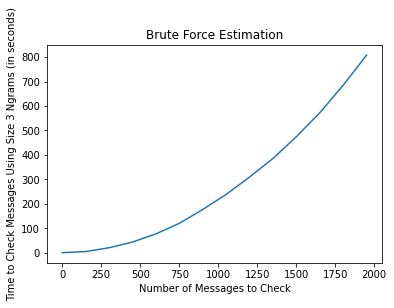

In [ ]:
# gc.collect()
# plt.plot(x, y)
# plt.xlabel('Number of Messages to Check')
# plt.ylabel('Time to Check Messages Using Size 3 Ngrams (in seconds)')
# plt.title('Brute Force Estimation')
# plt.show()

<font size="+1" color="red">Add your text below  for
    
    (1) a brief commmentary about what you see in this plot, and
    (2) your estimate for how long would it take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds, and justify it.</font>

1. I see a curve resembling that of exponential growth. This shows that the time complexity is probably O(n^2).

2. The entire input matrix has size of 10000. Looking from the graph, we see that when n = 2000, the time complexity is 800. To find the constant c we can use c = n^2/time_complexity = 2000^2/800 = 5000. So an estimate of the time complexity would be n^2/5000. If n 10000, 10000^2/5000=20000 seconds = 333.333333 minutes = 5.55555555 hours.

# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

This is normally done by hashing the ngrams and then every row as an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.


## 4.1 Create list of all ngrams

Implement code to create the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number) and to create the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

```python
NGRAM_SIZE = 3

ngram_to_index = {}
next_index = 0


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on how you `clean()` text. In this dataset it should be about 10 times the number of documents.



<font size="+1" color="red">Add your code below for creating the ngram_to_index structure.</font>

In [ ]:
NGRAM_SIZE = 3

ngram_to_index = {}
next_index = 0


for message in messages:
  all_ngrams = ngrams(message, NGRAM_SIZE)
  for ngram in all_ngrams:
    if ngram not in ngram_to_index:
      ngram_to_index[ngram] = next_index
      next_index += 1

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 63346 distinct ngrams in the 10000 documents


In [ ]:
ngram_to_index

{'aramateix gestio del': 0,
 'gestio del telefon': 1,
 'del telefon datencio': 2,
 'telefon datencio 061': 3,
 'datencio 061 depen': 4,
 '061 depen ferrovial': 5,
 'depen ferrovial decisio': 6,
 'ferrovial decisio del': 7,
 'decisio del govern': 8,
 'del govern modifica': 9,
 'govern modifica això': 10,
 'modifica això gent': 11,
 'això gent pagara': 12,
 'gent pagara manera': 13,
 'pagara manera': 14,
 'totbadalona els restaurants': 15,
 'els restaurants han': 16,
 'restaurants han reduir': 17,
 'han reduir seu': 18,
 'reduir seu aforament': 19,
 'seu aforament per': 20,
 'aforament per garantir': 21,
 'per garantir seguretat': 22,
 'garantir seguretat davant': 23,
 'seguretat davant del': 24,
 'davant del coronavirus': 25,
 'del coronavirus badalona': 26,
 'coronavirus badalona https': 27,
 'badalona https': 28,
 'xsalaimartin temps que': 29,
 'temps que sabem': 30,
 'que sabem que': 31,
 'sabem que aquest': 32,
 'que aquest tal': 33,
 'aquest tal garciapage': 34,
 'tal garciapage mi

Test your function by printing the ngram_to_index of the string `"tancat escoles fins"`. The exact index varies,  depending on how you `clean()` text.



<font size="+1" color="red">Add your code below  for testing the ngram_to_index structure.</font>

In [ ]:
print(ngram_to_index.get("tancat escoles fins"))

812


## 4.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.



In [ ]:
# Create matrix filled with boolean False
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print number of rows and columns
print("Rows: %d (distinct shingles)" % len(M_ngram_doc))
print("Columns: %d (distinct documents)" % len(M_ngram_doc[0]))

Rows: 63346 (distinct shingles)
Columns: 10000 (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`. You can use the following skeleton:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```



<font size="+1" color="red">Add your code below  for filling the M_ngram_doc matrix.</font>

In [ ]:
ngram_size=3
for docid in range(len(messages)):
  message = messages[docid]
  all_ngrams = ngrams(message, ngram_size)
  # if len(all_ngrams) < ngram_size:
  #   continue
  for ngram in all_ngrams:
    if ngram_to_index.get(ngram) is None:
      print(ngram, docid)
    M_ngram_doc[ngram_to_index.get(ngram)][docid] = True

Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. Print the following for messages number 28 and 3689:

```
Positions of non-zeros in column of docid 28 of M_ngram_doc
Clean message : rt 324cat el bce decep els inversors en plena crisi del coronavirus i libex sensorra un 14 el record duna sessio httpstcotqsf
Non-zeros     : [347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
```

Note that the specific ngram ids you will get depend on your cleanup process.



<font size="+1" color="red">Add your code below  for printing rows 28 and 3689 of the M_ngram_doc matrix.</font>

In [ ]:
print(clean(messages[28]))
print(M_ngram_doc[:, 28])
print(clean(messages[3689]))
print(M_ngram_doc[:, 3689])

rt 324cat el bce decep els inversors en plena crisi del coronavirus i libex sensorra un 14 el record duna sessio httpstcotqsf
[False False False ... False False False]
rt elpuntavui coronavirus tancat lespai aeri de la conca dòdena es prohibeixen els vols daeronaus i es restringeixen els daparells
[False False False ... False False False]


In [ ]:
print(ngrams(messages[28], 3))

['324cat bce decep', 'bce decep els', 'decep els inversors', 'els inversors plena', 'inversors plena crisi', 'plena crisi del', 'crisi del coronavirus', 'del coronavirus libex', 'coronavirus libex sensorra', 'libex sensorra record', 'sensorra record duna', 'record duna sessio', 'duna sessio httpstcotqsf', 'sessio httpstcotqsf']


In [ ]:
print(np.count_nonzero(M_ngram_doc[:, 28]))
print(len([347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]))

14
13


# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function `random.shuffle(...)` might be useful, and if you want to use `range(...)`, which returns an iterator, you will need to convert it to a list using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.



<font size="+1" color="red">Add your code below  for "random_permutation"</font>

In [ ]:
def random_permutation(k: int) -> list:
  """
  Generates a random permutation of the array of range [0,.... k-1]

  Parameters
  ----------
  k: int

  Returns
  -------
  list
    Permutation of k elements
  """

  k_list = list(range(k))
  random.shuffle(k_list)
  return k_list

Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.



In [ ]:
# Permute a list according to a permutation
def permuter(original_list, permutation):
  permuted_list = []
  for index in permutation:
    permuted_list.append(original_list[index])
  return permuted_list

# Code for testing permutations
original_list_1 = ["a", "b", "c", "d", "e"]
original_list_2 = ["alpha", "beta", "gamma", "delta", "epsilon"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['e', 'b', 'd', 'a', 'c']
['epsilon', 'beta', 'delta', 'alpha', 'gamma']

Test another permutation
['c', 'b', 'd', 'a', 'e']
['gamma', 'beta', 'delta', 'alpha', 'epsilon']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.



In [ ]:
NUM_PERMUTATIONS = 4

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))

# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 9447, 31830, 59164, ...
Permutation 1: 60301, 23560, 28500, ...
Permutation 2: 40274, 50705, 4365, ...
Permutation 3: 31015, 17848, 10006, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```


<font size="+1" color="red">Add your code below  for creating M_signature_doc</font>

In [ ]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
  for shingle_id in permutation:
    if M_ngram_doc[shingle_id, docid] == True:
    # if M_ngram_doc[shingle_id][docid] == True:
      return shingle_id
  return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
  print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
  permutation = permutations[permutation_num]
  for docid in range(len(messages)):
    if docid % 1000 == 0:
      print("- Scanning document %d of %d" % (docid, len(messages)))
    first_ngram = find_first_one(docid, permutation)
    M_signature_doc[permutation_num][docid] = first_ngram


Creating signatures for permutation 1/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [ ]:
M_signature_doc

array([[8.0000e+00, 1.8000e+01, 3.2000e+01, ..., 6.3344e+04, 4.0715e+04,
        3.8466e+04],
       [9.0000e+00, 2.3000e+01, 3.2000e+01, ..., 6.3341e+04, 4.0716e+04,
        3.8466e+04],
       [8.0000e+00, 1.7000e+01, 3.4000e+01, ..., 6.3335e+04, 2.5545e+04,
        7.7250e+03],
       [1.3000e+01, 2.2000e+01, 3.8000e+01, ..., 6.3344e+04, 4.0712e+04,
        3.8458e+04]])

Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.



In [ ]:
def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))


i = 84
j = 6586

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #84
Message       : RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Clean message : rt emergenciescat  es demana a la ciutadania limitar al maxim i si es pot evitar desplaçaments de cap de setmana tot el que sigui ma
Ngrams        : [218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229]
Signature     : [220.0, 225.0, 218.0, 220.0]

Document #6586
Message       : RT @emergenciescat: ⚠️ El @govern demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS innecessaris. Tot el que sigui…
Clean message : rt emergenciescat  el govern demana a la ciutadania limitar al maxim i si es pot evitar desplaçaments innecessaris tot el que sigui
Ngrams        : [218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229]
Signature     : [220.0, 3618.0, 3620.0, 3617.0]


# 5. Compare all pairs of signatures

Now we are ready to compare all documents by their signatures, instead of by their content. Write code to compare all pairs of documents. Use the following template:

```python
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

    # Counters for partial and complete signature matches
    count_sig_matches_partial = 0
    count_sig_matches_complete = 0

    # Extract the signature of the doc1
    signature1 = extract_signature(docid1)
    if docid1 % 500 == 0:
        print("%d/%d documents scanned" % (docid1, len(messages)))
    
    # Iterate through documents with docid larger than doc1
    for docid2 in range(docid1+1, len(messages)):
        
        # If this has not already been marked as duplicate of another document
        if docid2 not in is_possible_duplicate:
            
            # Extract signature of doc2
            signature2 = extract_signature(docid2)
            
            # REPLACE THIS COMMENT WITH YOUR CODE:
            # - Increase count_sig_matches* as needed
            # - Include docid2 in is_possible_duplicate if needed
            
    # REPLACE THIS COMMENT WITH YOUR CODE
    # - If the number of partial and complete matches exceeds a threshold
    #   print the document doc1 and indicate how many matches it has
```



<font size="+1" color="red">Add your code below for comparing all signatures</font>

In [ ]:
jaccard_threshold= 0.5
is_possible_duplicate = {}
partial_match_threshold = 3
complete_match_threshold = 3

# Iterate through all documents
for docid1 in range(len(messages)):

  # Counters for partial and complete signature matches
  count_sig_matches_partial = 0
  count_sig_matches_complete = 0

  # Extract the signature of the doc1
  signature1 = extract_signature(docid1)
  if docid1 % 500 == 0:
    print("%d/%d documents scanned" % (docid1, len(messages)))

  # Iterate through documents with docid larger than doc1
  for docid2 in range(docid1+1, len(messages)):

    # If this has not already been marked as duplicate of another document
    if docid2 not in is_possible_duplicate:

      # Extract signature of doc2
      signature2 = extract_signature(docid2)

      # - Increase count_sig_matches* as needed
      jaccard_index = jaccard_similarity(signature1, signature2)
      if jaccard_index == 1.0:
        count_sig_matches_complete +=1
        is_possible_duplicate[docid2] = signature2
      elif jaccard_index >= jaccard_threshold:
        count_sig_matches_partial += 1
        is_possible_duplicate[docid2] = signature2

  #   If the number of partial and complete matches exceeds a threshold
  #   print the document doc1 and indicate how many matches it has
  if count_sig_matches_partial >= partial_match_threshold or count_sig_matches_complete >= complete_match_threshold:
    print(f"{docid1} has {count_sig_matches_partial} partial matches and {count_sig_matches_complete} complete matches")


0/10000 documents scanned
2 has 0 partial matches and 26 complete matches
14 has 0 partial matches and 14 complete matches
16 has 0 partial matches and 71 complete matches
19 has 0 partial matches and 11 complete matches
20 has 0 partial matches and 29 complete matches
22 has 0 partial matches and 26 complete matches
24 has 2 partial matches and 11 complete matches
25 has 0 partial matches and 32 complete matches
32 has 21 partial matches and 20 complete matches
42 has 30 partial matches and 19 complete matches
53 has 0 partial matches and 57 complete matches
58 has 0 partial matches and 10 complete matches
59 has 0 partial matches and 11 complete matches
63 has 0 partial matches and 25 complete matches
70 has 0 partial matches and 13 complete matches
73 has 29 partial matches and 17 complete matches
79 has 0 partial matches and 10 complete matches
82 has 0 partial matches and 16 complete matches
94 has 7 partial matches and 18 complete matches
95 has 1 partial matches and 48 complete 

# 6.1 Dataset-2: Plagiarization Detection

This dataset has 4 files (right click to download or use `wget` command):

- [articles_100.train](https://cis331.guihang.org/data/lsh/articles_100.train)
- [articles_100.truth](https://cis331.guihang.org/data/lsh/articles_100.truth)
- [articles_10000.train](https://cis331.guihang.org/data/lsh/articles_10000.train)
- [articles_10000.truth](https://cis331.guihang.org/data/lsh/articles_10000.truth)

File "\*.train" contain articles, one per line with leading `word` as id.
"\*.truth" contain articles id pairs, indicating
plagiarization labels (two articles have high similarity).

You want to use \*_100.\* set as your play ground to test your program, and finally you will deliver:

1. Your code as a function (it can call other functions, which. is preferred work flow) to read the "articles_100.train" file for 100 articles, then to use `datasketch` package to detect pairs of "similar" articles, and print ids as shown in "\*.truth" (function input : filename; k as size of shingles/grams; threshold and/ or `b`, `r`; `nperms` as # of permutations)
2. You want to show at least several different sets of parameters `k`, `b`, `r` (or `threshold`) for each `nperms` and you want to show the rough range of your parameters that give output matching the "articles_100.truth" file (you can loop your parameters over certain range).
  - use `nperms` = {32, 64, 128, 256}, note its relation with run time.
3. You want to further test your function against 10000 articles, tweaking parameters if necessary and explain why you want to tweak that way, to match the `\*.truth` file.
  - use `nperms` = {32, 64, 128, 256}, note its relation with run time.
4. Finally print out the best running time for detection in 10000 articles and optimal parameters (you might find it helpful to do next task first) for each `nperms` value.



<font size="+1" color="red">Add your code below for tasks above</font>

## 6.1.1

In [ ]:
!wget https://cis331.guihang.org/data/lsh/articles_100.train
!wget https://cis331.guihang.org/data/lsh/articles_100.truth
!wget https://cis331.guihang.org/data/lsh/articles_10000.train
!wget https://cis331.guihang.org/data/lsh/articles_10000.truth

--2023-03-11 01:02:08--  https://cis331.guihang.org/data/lsh/articles_100.train
Resolving cis331.guihang.org (cis331.guihang.org)... 173.236.170.235
Connecting to cis331.guihang.org (cis331.guihang.org)|173.236.170.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156069 (152K)
Saving to: ‘articles_100.train.1’

articles_100.train. 100%[===================>] 152.41K   613KB/s    in 0.2s    

2023-03-11 01:02:09 (613 KB/s) - ‘articles_100.train.1’ saved [156069/156069]

--2023-03-11 01:02:09--  https://cis331.guihang.org/data/lsh/articles_100.truth
Resolving cis331.guihang.org (cis331.guihang.org)... 173.236.170.235
Connecting to cis331.guihang.org (cis331.guihang.org)|173.236.170.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59
Saving to: ‘articles_100.truth.1’

articles_100.truth. 100%[===================>]      59  --.-KB/s    in 0s      

2023-03-11 01:02:09 (13.1 MB/s) - ‘articles_100.truth.1’ saved [59/59]

--2023-03-11 0

In [ ]:
def read_articles(filepath: str) -> list:
  """
  Reads a text file with articles separated by new lines "\n" and returns a list
  of articles (strings).

  Parameters
  ----------
  filepath: str

  Returns
  -------
  list
    List of articles
  """
  with open(filepath, "r") as txt_file:
    articles = []
    for line in txt_file:
      articles.append(line)
    return articles


def split_id_text(raw_text: str) -> tuple:
  """
  Splits a string so the ID is separated from its content.

  Parameters
  ----------
  raw_text: str

  Returns
  -------
  tuple(str, str)
    Id, article contents

  Raises
  -------
  Exception
    If raw text is too short and/or is missing ID and/or article.
  """
  raw_text_list = raw_text.split()
  if len(raw_text_list) <= 1:
    raise Exception("Raw text is missing something (ID or article).")

  id = raw_text_list[0]
  text = " ".join(raw_text_list[1:]) #Everything after the first element of the list
  return id, text

def build_df(articles: list, ids: list) -> pd.DataFrame:
  """
  Builds a Pandas DataFrame from list of articles and list of article ids.

  Parameters
  ----------
  articles: list
  ids: list

  Returns
  -------
  pd.DataFrame
    DataFrame with 2 columns ('articles' and 'ids')

  Raises
  -------
  Exception
    If article length does not match ID length.
  """

  if len(articles) != len(ids):
    raise Exception("Article length must match ID length")

  df = pd.DataFrame()
  df['articles'] = articles
  df['ids'] = ids
  return df

def build_minhash(tokens: Sequence, num_perm: int):
  """
  Creates the minhash.

  Parameters
  ----------
  tokens: Sequence
    shingles/ngrams that are preprocessed and cleaned.
  num_perm: int
    Number of permutations to use. Constraint: >= 0

  Returns
  -------
  MinHash
    MinHash object from datasketch package.
  """
  m = MinHash(num_perm=num_perm)

  for token in tokens:
    m.update(token.encode('utf8'))
  return m

def build_lsh(minhashes: list, num_perm: int, threshold: float):
  """
  Builds LSH.

  Parameters
  ----------
  minhashes: list
    List of MinHash objects
  num_perm: int
    Number of permutations. Constraint: >= 0
  threshold: float
    Higher threshold = smaller false positive rate & larger false negative rate.
    Lower threshold = larger false positive rate & smaller false negative rate.

  Returns
  -------
  MinHashLSH
  """

  lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)

  for i,m in enumerate(minhashes):
    lsh.insert(i, m)

  return lsh

def get_plagiarized_ids(filepath:str) -> dict:
  """
  Creates a plagiarized dictionary to look up with articles are similar to each
  other according to the truth file.

  Parameters
  ----------
  filepath: str

  Returns
  -------
  dict
    Article ID as key and another article ID as value.
  """
  article_pairs = read_articles(filepath)
  plagiarize_dict = {}
  for pair in article_pairs:
    article1 = pair.split()[0]
    article2 = pair.split()[1]

    plagiarize_dict[article1] = article2
    plagiarize_dict[article2] = article1

  return plagiarize_dict

def find_similar_articles(train_filepath: str, k: int, threshold: float, nperms: int, truth_filepath: str = '/content/articles_100.truth', skip: bool = False) -> tuple:
  """
  Finds similar pairs of articles using MinHash LSH and the error rate given the
  truth file.

  Parameters
  ----------
  train_filepath: str
    Filepath for training data.
  k: int
    The 'n' of ngrams or 'k' of k shingles. The number of words to contain per
    sequence. Constraint: k >= 1
  threshold: float
    The threshold that must be satisfied for articles to be considered similar.
    Range: [0.0, 1.0]
  nperms: int
    Number of permutations to use for MinHash and LSH.
  truth_filepath: str, optional
    Text filepath containing 2 similar articles per line separated by space.
    Defaults to '/content/articles_100.truth'
    Example: "t980 t2023"
  skip: bool, optional
    Whether or not to skip article IDs not in the truth file.
    Defaults to False.

  Returns
  -------
  tuple(set, float)
    Tuple containing set of similar articles and the error rate (% we got wrong).
  """
  all_articles = read_articles(train_filepath)
  tokens, ids, all_clean_articles, minhash = [], [], [], []
  id_article_dict = {}
  plagiarize_id_dict = get_plagiarized_ids(truth_filepath)

  for i in all_articles:
    id, article = split_id_text(i)
    all_clean_articles.append(clean(article))
    ids.append(id)
    id_article_dict[id] = clean(article)
    tokens = ngrams(article, k)

    m = build_minhash(tokens, nperms)
    minhash.append(m)

  lsh = build_lsh(minhash, nperms, threshold)

  df = build_df(all_clean_articles, ids)
  skipped_articles = set()
  similar_articles = set()
  predicted_correct_count = 0
  predicted_wrong = 0


  for index, m in enumerate(minhash):
    id = ids[index]
    actual_plagiarize_id = plagiarize_id_dict.get(id, '').strip()

    if actual_plagiarize_id == '' and skip == False:
      skipped_articles.add(df['ids'][index])
      continue

    lsh_query_results = lsh.query(m)
    lsh_query_results = [ids[i].strip() for i in lsh_query_results if i != index]

    if actual_plagiarize_id in lsh_query_results:
      predicted_correct_count += 1
      similar_articles.add((id, lsh_query_results[0]))
    else:
      predicted_wrong += 1
      print(f"ID: {id} Prediction: {lsh_query_results} Actual Plagiarized ID {actual_plagiarize_id}")

  print(f"Articles skipped because they were not in truth file: {skipped_articles}")
  print(f"Predicted correctly: {predicted_correct_count} Predicted incorrectly: {predicted_wrong}")
  error = predicted_wrong /(predicted_correct_count+predicted_wrong)


  return similar_articles, error

In [ ]:
similar_test, test_error = find_similar_articles('/content/articles_100.train', 3, 0.7, 32, '/content/articles_100.truth')
print(test_error)
similar_test

Articles skipped because they were not in truth file: {'t3179', 't3797', 't3172', 't9530', 't5294', 't3170', 't3795', 't7072', 't9532', 't5201', 't5296', 't8369', 't8337', 't5297', 't5202', 't6524', 't3798', 't3790', 't3178', 't8664', 't5439', 't5437', 't9536', 't8474', 't8660', 't6000', 't9533', 't6529', 't7445', 't3796', 't5298', 't3799', 't3828', 't5431', 't6523', 't8476', 't6186', 't8475', 't3177', 't5438', 't9537', 't6521', 't3794', 't5293', 't8368', 't9514', 't3829', 't5291', 't6527', 't3792', 't6526', 't6525', 't8470', 't9531', 't9535', 't5295', 't8662', 't5290', 't5436', 't5430', 't5434', 't5205', 't3173', 't5292', 't8661', 't5435', 't7075', 't3176', 't3175', 't8477', 't8665', 't5204', 't3791', 't3171', 't5207', 't5433', 't8001', 't5299', 't9534', 't9516', 't5432', 't3793', 't5234', 't6528', 't7443', 't5203', 't3174', 't6522', 't1233', 't1235'}
Predicted correctly: 10 Predicted incorrectly: 0
0.0


{('t1088', 't5015'),
 ('t1297', 't4638'),
 ('t1768', 't5248'),
 ('t1952', 't3495'),
 ('t2023', 't980'),
 ('t3495', 't1952'),
 ('t4638', 't1297'),
 ('t5015', 't1088'),
 ('t5248', 't1768'),
 ('t980', 't2023')}

## 6.1.2

In [ ]:
running_times = {}
error_rates = {}
all_nperms = [32, 64, 128, 256]
all_thresholds = [0.3, 0.5, 0.7, 0.9]
all_k = [2, 3, 4, 5]

In [ ]:
def test_time(nperm: int, k: int = 3, threshold: float = 0.7, train_filepath: str = '/content/articles_100.train', truth_filepath: str = '/content/articles_100.truth') -> float:
  t_start = perf_counter()
  _, err = find_similar_articles(train_filepath, k, threshold, nperm, truth_filepath=truth_filepath)
  t_end = perf_counter()
  return (t_end-t_start, err)

In [ ]:
for i in all_nperms:
  for threshold in all_thresholds:
    for k in all_k:
      running_time, err = test_time(nperm=i, k=k, threshold=threshold)
      running_times[(i, k, threshold)] = running_time
      error_rates[(i, k, threshold)] = err
      print(f"{i} took {running_time} seconds to run using {threshold} as threshold and {k} as k")

Articles skipped because they were not in truth file: {'t3179', 't3797', 't3172', 't9530', 't5294', 't3170', 't3795', 't7072', 't9532', 't5201', 't5296', 't8369', 't8337', 't5297', 't5202', 't6524', 't3798', 't3790', 't3178', 't8664', 't5439', 't5437', 't9536', 't8474', 't8660', 't6000', 't9533', 't6529', 't7445', 't3796', 't5298', 't3799', 't3828', 't5431', 't6523', 't8476', 't6186', 't8475', 't3177', 't5438', 't9537', 't6521', 't3794', 't5293', 't8368', 't9514', 't3829', 't5291', 't6527', 't3792', 't6526', 't6525', 't8470', 't9531', 't9535', 't5295', 't8662', 't5290', 't5436', 't5430', 't5434', 't5205', 't3173', 't5292', 't8661', 't5435', 't7075', 't3176', 't3175', 't8477', 't8665', 't5204', 't3791', 't3171', 't5207', 't5433', 't8001', 't5299', 't9534', 't9516', 't5432', 't3793', 't5234', 't6528', 't7443', 't5203', 't3174', 't6522', 't1233', 't1235'}
Predicted correctly: 10 Predicted incorrectly: 0
32 took 1.0321619009991991 seconds to run using 0.3 as threshold and 2 as k
Articles s

In [ ]:
print(running_times)

{(32, 2, 0.3): 1.0321619009991991, (32, 3, 0.3): 1.0524933310007327, (32, 4, 0.3): 1.380862027999683, (32, 5, 0.3): 1.341804798998055, (32, 2, 0.5): 1.0379766520018165, (32, 3, 0.5): 1.0199716509996506, (32, 4, 0.5): 1.037035000998003, (32, 5, 0.5): 1.0357332410021627, (32, 2, 0.7): 1.0109982709982432, (32, 3, 0.7): 1.000998030998744, (32, 4, 0.7): 1.0318664309997985, (32, 5, 0.7): 1.0018497620003473, (32, 2, 0.9): 1.0159218709995912, (32, 3, 0.9): 1.324414918999537, (32, 4, 0.9): 1.3509860180020041, (32, 5, 0.9): 0.9919187209998199, (64, 2, 0.3): 1.0515586509973218, (64, 3, 0.3): 1.0497375910017581, (64, 4, 0.3): 1.0542100310012756, (64, 5, 0.3): 1.0378089510013524, (64, 2, 0.5): 1.0494993909996992, (64, 3, 0.5): 1.0076296420011204, (64, 4, 0.5): 1.0538471809995826, (64, 5, 0.5): 1.04497376099971, (64, 2, 0.7): 1.3779818980001437, (64, 3, 0.7): 1.3201693590017385, (64, 4, 0.7): 1.0486791010007437, (64, 5, 0.7): 1.0387834419998399, (64, 2, 0.9): 1.042718700999103, (64, 3, 0.9): 1.08250

In [ ]:
for key in running_times:
  perm = key[0]
  k = key[1]
  threshold = key[2]
  running_time = running_times[key]
  print(f"{perm} took {running_time} seconds to run using {threshold} as threshold and {k} as k")

32 took 1.0321619009991991 seconds to run using 0.3 as threshold and 2 as k
32 took 1.0524933310007327 seconds to run using 0.3 as threshold and 3 as k
32 took 1.380862027999683 seconds to run using 0.3 as threshold and 4 as k
32 took 1.341804798998055 seconds to run using 0.3 as threshold and 5 as k
32 took 1.0379766520018165 seconds to run using 0.5 as threshold and 2 as k
32 took 1.0199716509996506 seconds to run using 0.5 as threshold and 3 as k
32 took 1.037035000998003 seconds to run using 0.5 as threshold and 4 as k
32 took 1.0357332410021627 seconds to run using 0.5 as threshold and 5 as k
32 took 1.0109982709982432 seconds to run using 0.7 as threshold and 2 as k
32 took 1.000998030998744 seconds to run using 0.7 as threshold and 3 as k
32 took 1.0318664309997985 seconds to run using 0.7 as threshold and 4 as k
32 took 1.0018497620003473 seconds to run using 0.7 as threshold and 5 as k
32 took 1.0159218709995912 seconds to run using 0.9 as threshold and 2 as k
32 took 1.324414

The larger the number of permutations, the longer it takes.

## 6.1.3

In [ ]:
running_times = {}
error_rates = {}
all_nperms = [32, 64, 128, 256]
all_thresholds = [0.5, 0.7, 0.9]
all_k = [2, 3, 5]

In [ ]:
for i in all_nperms:
  for threshold in all_thresholds:
    for k in all_k:
      running_time, err = test_time(nperm=i, k=k, threshold=threshold,
                               train_filepath='/content/articles_10000.train',
                               truth_filepath='/content/articles_10000.truth')
      running_times[(i, k, threshold)] = running_time
      error_rates[(i, k, threshold)] = err
      print(f"{i} took {running_time} seconds to run using {threshold} as threshold and {k} as k")

Articles skipped because they were not in truth file: {'t5538', 't4368', 't8670', 't8075', 't3155', 't2351', 't1437', 't7743', 't680', 't2610', 't3170', 't1968', 't2462', 't3904', 't9344', 't8726', 't555', 't9532', 't3154', 't5404', 't8593', 't5282', 't6240', 't1218', 't1715', 't2710', 't1650', 't8293', 't9082', 't1759', 't2914', 't8821', 't9889', 't6793', 't1502', 't6384', 't756', 't8540', 't5510', 't3798', 't3113', 't2091', 't2190', 't7410', 't9260', 't3425', 't6318', 't4352', 't5803', 't6329', 't6889', 't238', 't9742', 't9914', 't6872', 't1553', 't578', 't9461', 't3930', 't2147', 't995', 't892', 't5539', 't3625', 't2205', 't4232', 't5053', 't6044', 't2110', 't8813', 't9903', 't4587', 't9784', 't9310', 't5470', 't9629', 't5080', 't4731', 't2793', 't2207', 't5002', 't2332', 't3661', 't915', 't2362', 't2418', 't5409', 't9707', 't6252', 't2422', 't4061', 't179', 't8276', 't8448', 't2545', 't327', 't868', 't4557', 't4143', 't1855', 't3951', 't5156', 't8358', 't2693', 't5948', 't1958', 't

In [ ]:
for key in running_times:
  perm = key[0]
  k = key[1]
  threshold = key[2]
  running_time = running_times[key]
  print(f"{perm} took {running_time} seconds to run using {threshold} as threshold and {k} as k. The error rate is {error_rates[key]}")

32 took 108.61301368000204 seconds to run using 0.5 as threshold and 2 as k. The error rate is 0.0
32 took 108.25897257399993 seconds to run using 0.5 as threshold and 3 as k. The error rate is 0.0
32 took 107.87484850499823 seconds to run using 0.5 as threshold and 5 as k. The error rate is 0.0
32 took 114.45492728099998 seconds to run using 0.7 as threshold and 2 as k. The error rate is 0.0
32 took 119.61449673699826 seconds to run using 0.7 as threshold and 3 as k. The error rate is 0.0
32 took 120.72145092800201 seconds to run using 0.7 as threshold and 5 as k. The error rate is 0.0
32 took 123.60141312300038 seconds to run using 0.9 as threshold and 2 as k. The error rate is 0.025
32 took 126.28949844100134 seconds to run using 0.9 as threshold and 3 as k. The error rate is 0.05
32 took 134.77009036199888 seconds to run using 0.9 as threshold and 5 as k. The error rate is 0.1125
64 took 127.63007712099716 seconds to run using 0.5 as threshold and 2 as k. The error rate is 0.0
64 t

In [ ]:
#Find smallest error
smallest_err_rate = 1.0
optimal_err_params = set()
for key, err_rate in error_rates.items():
  if err_rate < smallest_err_rate:
    smallest_err_rate = err_rate
    optimal_err_params = {key,}
  if err_rate == smallest_err_rate:
    optimal_err_params.add(key)
print(smallest_err_rate)
print(optimal_err_params)

0.0
{(128, 5, 0.5), (32, 2, 0.5), (128, 3, 0.5), (32, 5, 0.7), (64, 3, 0.5), (256, 2, 0.5), (64, 2, 0.7), (256, 3, 0.7), (128, 3, 0.9), (256, 5, 0.7), (64, 5, 0.5), (128, 2, 0.5), (32, 3, 0.5), (256, 2, 0.9), (128, 5, 0.7), (32, 5, 0.5), (128, 2, 0.9), (32, 2, 0.7), (64, 2, 0.5), (128, 3, 0.7), (256, 3, 0.5), (64, 3, 0.7), (256, 5, 0.5), (256, 2, 0.7), (64, 5, 0.7), (256, 3, 0.9), (128, 2, 0.7), (32, 3, 0.7)}


In [ ]:
# Find fastest time for smallest errors
fastest_time = 1000
optimal_params = set()
fastest_time_error_rate = set()
for key, run_time in running_times.items():
  if key not in optimal_err_params:
    continue
  if run_time < fastest_time:
    fastest_time = run_time
    optimal_params = {key,}
    fastest_time_error_rate = {error_rates[key], }
  if run_time == fastest_time:
    optimal_params.add(key)
    fastest_time_error_rate.add(error_rates[key])
print(fastest_time)
print(optimal_params)
print(fastest_time_error_rate)

107.87484850499823
{(32, 5, 0.5)}
{0.0}


The final parameters for 10000 articles is 32 permutations, k=5, and 0.5 threshold because the error rate is the smallest and it also has the fastest running time.

## 6.1.4

In [ ]:
def find_fastest_time(perm_to_test: int):
  fastest_time = 1000
  optimal_params = set()
  fastest_time_error_rate = set()
  for key, run_time in running_times.items():
    if key[0] != perm_to_test:
      continue
    if run_time < fastest_time:
      fastest_time = run_time
      optimal_params = {key,}
      fastest_time_error_rate = {error_rates[key], }
    if run_time == fastest_time:
      optimal_params.add(key)
      fastest_time_error_rate.add(error_rates[key])
  print(f"Fastest time: {fastest_time}")
  print(f"Optimal Parameters(permutaions, k, threshold): {optimal_params}")
  print(f"Error rate for fastest time params.: {fastest_time_error_rate}")

In [ ]:
# Find fastest time for n = 32
find_fastest_time(32)

Fastest time: 107.87484850499823
Optimal Parameters(permutaions, k, threshold): {(32, 5, 0.5)}
Error rate for fastest time params.: {0.0}


In [ ]:
# Find fastest time for n = 64
find_fastest_time(64)

Fastest time: 112.068317543999
Optimal Parameters(permutaions, k, threshold): {(64, 2, 0.9)}
Error rate for fastest time params.: {0.0375}


In [ ]:
# Find fastest time for n = 128
find_fastest_time(128)

Fastest time: 118.9124847819985
Optimal Parameters(permutaions, k, threshold): {(128, 5, 0.9)}
Error rate for fastest time params.: {0.025}


In [ ]:
# Find fastest time for n = 256
find_fastest_time(256)

Fastest time: 132.0426008909999
Optimal Parameters(permutaions, k, threshold): {(256, 5, 0.9)}
Error rate for fastest time params.: {0.05}


In [ ]:
from scipy.integrate import quad as integrate
def false_positive_probability(threshold, b, r):
  _prob = lambda t : 1 - (1 - t**float(r))**float(b)
  a, err = integrate(_prob, 0.0, threshold)
  return a


def false_negative_probability(threshold, b, r):
  _prob = lambda t : (1 - t**float(r))**float(b)
  a, err = integrate(_prob, threshold, 1.0)
  return a

def find_factors(num: int) -> list:
  return {(i,num//i) for i in range(1, num + 1) if num % i == 0}

def optimal_band_row(total_rows=128, false_negative_weight=1.0, false_positive_weight=1.0, threshold=0.75):
  all_factors = find_factors(total_rows)
  smallest_error = 1.0
  best_band = None
  best_row = None
  for i in all_factors:

    err = false_positive_weight * false_positive_probability(threshold, i[0], i[1]) + false_negative_weight * false_negative_probability(threshold, i[0], i[1])
    if err < smallest_error:
      smallest_error = err
      best_band = i[0]
      best_row = i[1]

  return smallest_error, best_band, best_row

In [ ]:
optimal_band_row(32, threshold=0.5)

(0.047072898214890566, 1000, 10)

In [ ]:
optimal_band_row(64, threshold=0.9)

(0.04842164633294423, 4, 16)

In [ ]:
optimal_band_row(128, threshold=0.9)

(0.04490915660033154, 4, 32)

In [ ]:
optimal_band_row(256, threshold=0.9)

(0.033358084146165715, 8, 32)

# 6.2 Prob(FN) and Prob(FP) computation in Python

- Note: Recall the LSH algorithm we learned in the class states that as long as at least one band has two columns hashing into the same bucket, we claim these two columns (docs) are similar. The prob. estimation is as follows:

Assume $t=Jaccard(C_1, C_2)$
- Pick any band (r rows)
    - Prob. ( all rows in band equal ) = $t^r $
    - Prob. ( some row in band unequal ) = $1 - t^r$

- Prob. ( no band identical ) = $(1 - t^r)^b$

- Prob. ( at least 1 band identical ) =                  			$1 - (1 - t^r)^b$

If our threshold for similarity is set to be $t_0$:

- Prob (False Positive/falsely claim unsimilar pair to be similar) =

$$\int_{t=0}^{t_0} (1 - (1 - t^r)^b) \,dt$$

- Prob (False Negative/missing target) =

$$\int_{t=t_0}^1  (1 - t^r)^b)\,dt$$



- False positive and false negative rate/prob are evaluated based upon the assumption that the similarity between any pair of docs are evenly distributed between 0 and 1.

**Python implementation:**

```python
from scipy.integrate import quad as integrate
def false_positive_probability(threshold, b, r):
    _prob = lambda t : 1 - (1 - t**float(r))**float(b)
    a, err = integrate(_prob, 0.0, threshold)
    return a


def false_negative_probability(threshold, b, r):
    _prob = lambda t : (1 - t**float(r))**float(b)
    a, err = integrate(_prob, threshold, 1.0)
    return a
```


#### Your task:

Write Python code to compute optimal b, r that yield smallest error for

a)
err = false_positive_probability + false_negative_probability , where b*r <=128

and

b)
err = false_positive_probability\*.2 + false_negative_probability\*.8 , where b*r <=128

c) create a plot like below.
![](https://cis331.guihang.org/data/lsh/r-b-prob.png)

Note:

- In `matplotlib` you can call plot function several times, the plots automatically overlay if they come from the same `axes` or `plt` object.   
- `plt.fill_between` or `axes.fill_between` will do shading.
- To draw any straight line, including vertical one, use `plot(x,y)` with x being a list with starting and ending points in x; similar for y.
- Please bookmark this page for plot examples and code:
https://matplotlib.org/3.1.1/gallery/index.html
- This particular one is more relevant:
https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html#sphx-glr-gallery-lines-bars-and-markers-fill-between-demo-py

<font size="+1" color="red">Add your code below for tasks above</font>

In [ ]:
from scipy.integrate import quad as integrate
def false_positive_probability(threshold, b, r):
  _prob = lambda t : 1 - (1 - t**float(r))**float(b)
  a, err = integrate(_prob, 0.0, threshold)
  return a


def false_negative_probability(threshold, b, r):
  _prob = lambda t : (1 - t**float(r))**float(b)
  a, err = integrate(_prob, threshold, 1.0)
  return a

def find_factors(num: int) -> list:
  return {(i,num//i) for i in range(1, num + 1) if num % i == 0}

def optimal_band_row(total_rows=128, false_negative_weight=1.0, false_positive_weight=1.0, threshold=0.75):
  all_factors = find_factors(total_rows)
  smallest_error = 1.0
  best_band = None
  best_row = None
  for i in all_factors:

    err = false_positive_weight * false_positive_probability(threshold, i[0], i[1]) + false_negative_weight * false_negative_probability(threshold, i[0], i[1])
    if err < smallest_error:
      smallest_error = err
      best_band = i[0]
      best_row = i[1]

  return smallest_error, best_band, best_row

### A

In [ ]:
minimal_error = 1.0
best_band = None
best_row = None

a_dict = {'errors': [],
          'bands': [],
          'rows': []}

for i in range(1,129):
  error, band, row = optimal_band_row(total_rows=i)
  a_dict['errors'].append(error)
  a_dict['bands'].append(band)
  a_dict['rows'].append(row)

  if error < minimal_error:
    minimal_error = error
    best_band = band
    best_row = row

print(f"Minimal error {minimal_error} was achieved from band number {best_band} and row number {best_row}")

Minimal error 0.0668078624495187 was achieved from band number 11 and row number 11


### B

In [ ]:
minimal_error = 1.0
best_band = None
best_row = None

b_dict = {'errors': [],
          'bands': [],
          'rows': []}

for i in range(1,129):
  error, band, row = optimal_band_row(total_rows=i, false_negative_weight=0.8, false_positive_weight=0.2)
  b_dict['errors'].append(error)
  b_dict['bands'].append(band)
  b_dict['rows'].append(row)
  if error < minimal_error:
    minimal_error = error
    best_band = band
    best_row = row

print(f"Minimal error {minimal_error} was achieved from band number {best_band} and row number {best_row}")

Minimal error 0.024243194966284524 was achieved from band number 16 and row number 8


### C

In [ ]:
def h(t,r,b):
  return 1- np.power(1 - np.power(t, r), b)

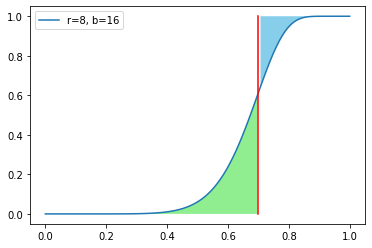

In [ ]:
graph_x = np.linspace (0,1,100)

y_curve =  h(t=graph_x, r=8, b=16)
plt.plot(graph_x, y_curve, label='r=8, b=16')
# plt.plot(graph_x, h(t=graph_x, r=4, b=32), label='r=4, b=32')

y_line = np.linspace(0.0, 1.0, 100)
x_line = np.repeat(0.7, len(y_line))
plt.plot(x_line, y_line, color='red')
plt.fill_between(graph_x, y_curve, 0,
                  where=graph_x <= 0.7, interpolate=True, facecolor='lightgreen')
plt.fill_between(graph_x, y_curve, 1,
                  where=graph_x >= 0.7, interpolate=True, facecolor='skyblue')
plt.legend()
plt.show()

# DELIVER (individually)


Submit this notebook on canvas.


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>

<font size="+1" color="red">Ian Liu</font>